In [1]:
%matplotlib widget

from utils import *

set_cache_dir('pickles/slides7')

import logging
import numpy as np
import matplotlib.pyplot as plt
import climada
import cartopy
import pickle
import warnings # To hide the warnings

# this is to hide warnings
logging.getLogger("climada").setLevel(logging.CRITICAL)
logging.getLogger(__name__).setLevel(logging.ERROR)

logging.basicConfig(level=logging.CRITICAL)

# Disable all logging
logging.disable(logging.CRITICAL)
warnings.simplefilter("ignore")

ERROR 1: PROJ: proj_create_from_database: Open of /home/arthur/miniforge3/envs/climada_env/share/proj failed


## Pareto distribution to model the intensity of granular events

In the case of granular event data (as opposed to annual maxima data), we saw that the general formula for the return period for an intensity $x$ is given by,

\begin{equation}
    T(x) = \frac{1}{\lambda (1 - F_X(x))},
\end{equation}

where,
1. $\lambda$ is the frequency of events, that is to say the number of events per year. E.g. if our record contains 10 events over 100 years, this corresponds to a frequency of
   $\lambda=0.1$ event per year.
3.  $F_X(x)$ is the Cumulative Distribution Function of the intensity of the events.

In the parametric case, we need a parametric family of probability distribution, with cumulative distribution function $F_X(x; \boldsymbol{\theta})$ where $\boldsymbol{\theta}$ is a parameter or a parameter vectors (if there are several parameters). While for annual maxima data we used the *Generalized Extreme Value distribution* (of which the Frechet distribution is a particular case), for granular event data we can instead use the *Pareto distribution*.

<div class="alert alert-block alert-success">
The Pareto distribution has probability density function,

\begin{equation}
    f_X(x; b) = \frac{bx_0^b}{x^{b + 1}}, \quad x\geq x_0, b>0.
\end{equation}

The intensity $x_0$ corresponds to the threshold intensity used for the definition of a natural disaster. 
</div>

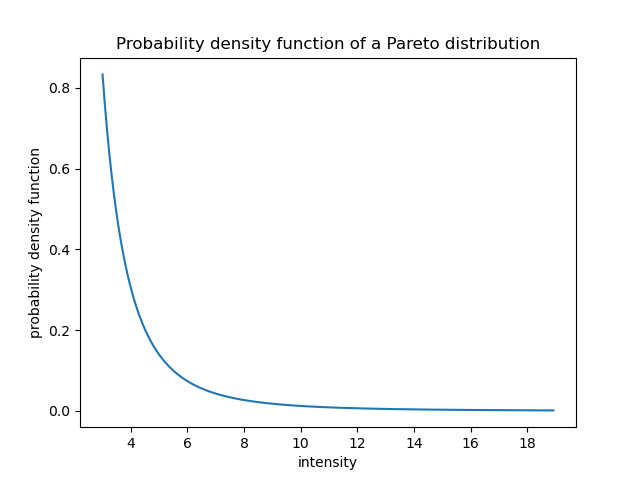

In [2]:
from scipy.stats import pareto

distribution = pareto(b=2.5, scale=3)
xmin, xmax = distribution.ppf(0.), distribution.ppf(0.99)
xs = np.linspace(xmin, xmax, 1000)

plt.figure()
plt.plot(xs, distribution.pdf(xs))
plt.xlabel('intensity')
plt.ylabel('probability density function')
plt.title('Probability density function of a Pareto distribution');

We can estimate the parameters of a Pareto distribution from data using Maximum Likelihood estimation.

In [3]:
from scipy.optimize import minimize

def func(x):
    b, sigma = x
    return - np.sum(np.log(b) + b * np.log(sigma) - (b + 1) * np.log(data))

#minimize(func, x0=[1.5, 1.5], bounds=[(1, 10), (1, np.min(data))], options=dict(ftol=1e-50))

## Monte Carlo simulations of natural disasters

Often, the situation occurs that we do not have enough events in our record to produce robust estimates of impact. A common approach to this issue is to use historical data to generate new *probable* events. These simulations are commonly called *Monte Carlo simulations*, or synthetic data.

The general idea is as follows: 

1. We start with $N$ real events from our record
2. For each event $j=1, \ldots, N$, we simulate $M$ Monte Carlo events

We need to be careful to adapt the frequency $\lambda$ in the general formula. How do you think we should adapt the frequency of each event in the dataset?

Similarly, the formula for the average annual impact needs to account for this.

## Application to Tropical Cyclones with Climada

Climada makes it easy to synthesize virtual tracks from a historical track. For instance, in the code below we load the track of the Tropical Cyclone Irma (2017) and synthesize 5 perturbed trajectories. Note that the intensity of the perturbed trajectories is set to decay when the tropical cyclones hits land.

```python
from climada.hazard import TCTracks

tr_irma = TCTracks.from_ibtracs_netcdf(
    provider="usa", storm_id="2017242N16333"
)  # IRMA 2017
ax = tr_irma.plot()
ax.set_title("IRMA")  # set title

tr_irma.equal_timestep()
tr_irma.calc_perturbed_trajectories(nb_synth_tracks=5)
tr_irma.plot();
```

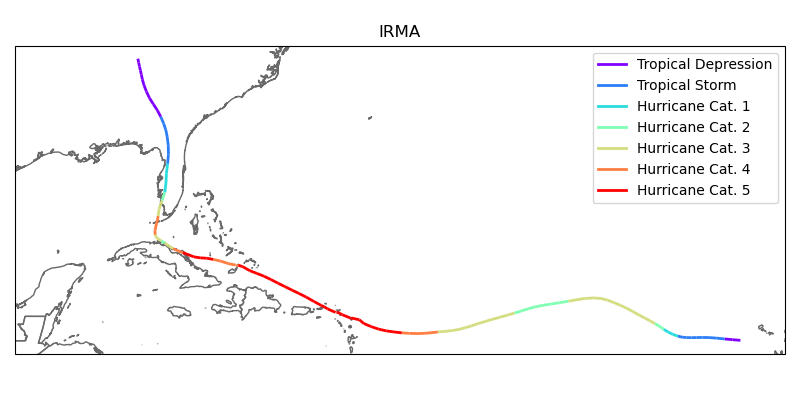

In [5]:
from utils import get_projection

from climada.hazard import TCTracks

try:
    tr_irma = load_from_cache('tr_irma0')

except FileNotFoundError:
    tr_irma = TCTracks.from_ibtracs_netcdf(
        provider="usa", storm_id="2017242N16333"
    )  # IRMA 2017
    save_to_cache('tr_irma0', tr_irma)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
tr_irma.plot(axis=ax)
ax.set_title("IRMA");  # set title

Text(0.5, 1.0, 'IRMA and 5 synthetic tracks')

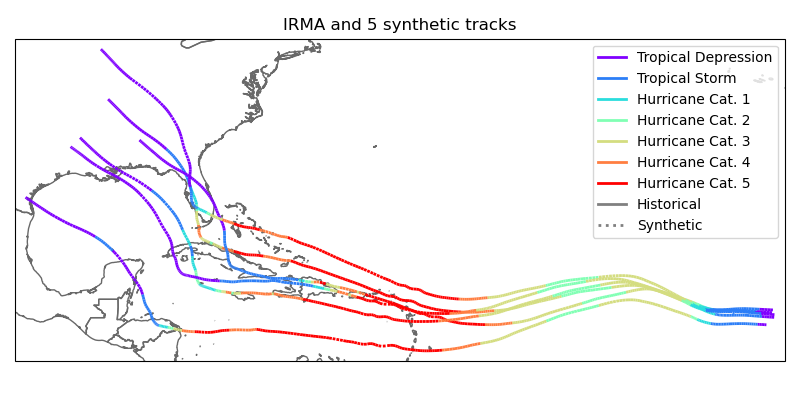

In [7]:
import cartopy.crs as crs

try:
    tr_irma = load_from_cache('tr_irma.pkl')

except:
    tr_irma.equal_timestep()
    tr_irma.calc_perturbed_trajectories(nb_synth_tracks=5)
    save_to_cache('tr_irma.pkl', tr_irma)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=crs.PlateCarree())
tr_irma.plot(axis=ax)
ax.set_title("IRMA and 5 synthetic tracks");

The way we now define a Hazard of type TropCyclone does not differ from what we saw before:
1. We define a set lof centroids / locations
2. We use the method `from_track` of the class TropCyclone and pass it `tr_irma`, which contains both the original track and the synthesized tracks.

```python
from climada.hazard import Centroids, TropCyclone

# construct centroids
min_lat, max_lat, min_lon, max_lon = 16, 21, -72, -61
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.5)
cent.plot()

# construct tropical cyclones
tc_irma = TropCyclone.from_tracks(tr_irma, centroids=cent)
```

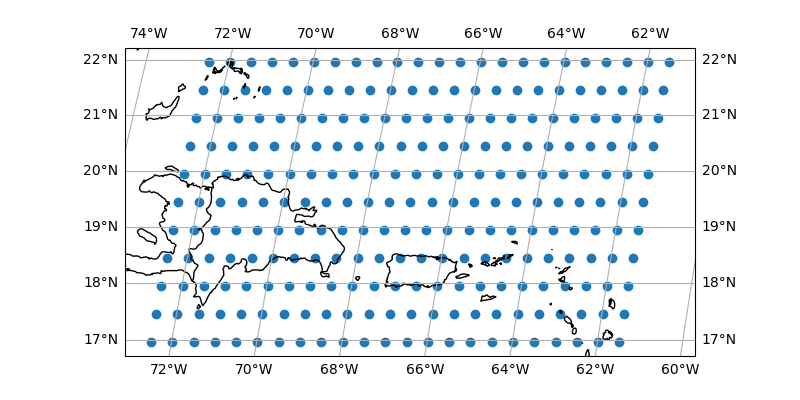

In [33]:
from climada.hazard import Centroids, TropCyclone

# construct centroids
min_lat, max_lat, min_lon, max_lon = 16.99375, 21.95625, -72.48125, -61.66875
cent = Centroids.from_pnt_bounds((min_lon, min_lat, max_lon, max_lat), res=0.5)

fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=get_projection())
cent.plot(axis=ax)

# construct tropical cyclones
try:
    tc_irma = load_from_cache('tc_irma')
except:
    tc_irma = TropCyclone.from_tracks(tr_irma, centroids=cent)
    save_to_cache('tc_irma', tc_irma)

<GeoAxes: title={'center': 'TC max intensity at each point'}>

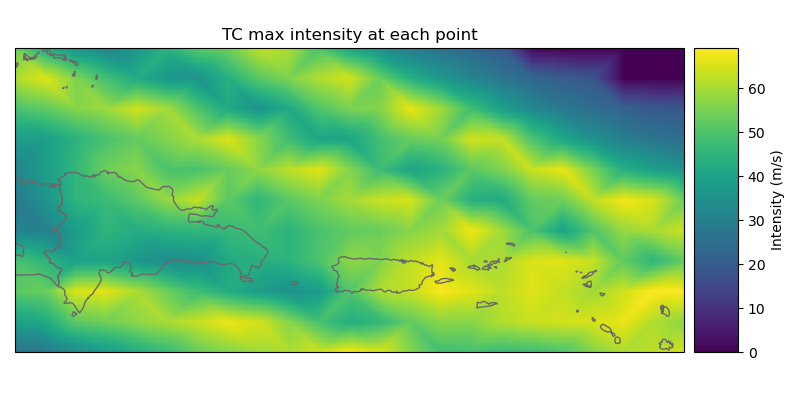

In [34]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(projection=crs.PlateCarree())
tc_irma.plot_intensity(0, axis=ax)

Now if we check the frequency array of tc_irma (which is of type TropCyclone, a class that inherits from the general class Hazard), we see that
we get $\frac{1}{5 + 1}$ (5 synthetic Tropical Cyclone tracks, one historic):

```python
print('Frequency of events: ', tc_irma.frequency)
```

In [11]:
print('Frequency of events: ', tc_irma.frequency)

Frequency of events:  [0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
